In [10]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import pathlib
from typing import List, Tuple
import uproot3

In [11]:
save_plots = False

## Pick what extra branches you want
with_dtf = True
with_pidsubs = False
with_protoparticles = True
with_2Ddebug = True
with_truevtx_kinematics = True

## Perform analysis with:
## - All data: 'b' (both)
## - Only Lambdas: 'm' (matter)
## - Only antiLambdas: 'a' (antimatter)
use_matter_antimatter = 'b'

## Choose colors
color_gen = 'tab:gray'
color_3D = 'tab:blue'
color_2D = 'tab:orange'

truth_match = False ## Failed attempt at truth matching, not needed

In [12]:
if use_matter_antimatter == 'b':
    event_category_label = 'All reconstructed events'
elif use_matter_antimatter == 'm':
    event_category_label = 'Only matter events'
elif use_matter_antimatter == 'a':
    event_category_label = 'Only antimatter events'
else:
    raise ValueError

In [13]:
input_file = '/scratch/user/adegenna/top50_xyz_seq/Lb2JPsiL_Run2_Sim_2016_MagUp_v12_VertexingDebug.root'

In [14]:
## Create plots directory, if missing
plots_dir = (str(pathlib.Path.home())
                  + '/vertex-reconstruction-studies/'
                  + 'plots/'
                  + 'studies_on_integrated_root_files/'
                  + 'xyz_sequential_blowup_performance_study/'
)
pathlib.Path(plots_dir).mkdir(parents=True, exist_ok=True)

# Import data (v2.1)

In [15]:
def root_file_to_df(
    filename: str,
    branches_ordinary: List[str] = [],
    branches_jagged: List[str] = [],   ## These are the protoparticles, really
    truth_tree: bool = False,
    slice_ordinary: bool = True
) -> pd.DataFrame:
    if len(branches_jagged) == 0:
        have_jagged = False
    else:
        have_jagged = True
    
    if len(branches_ordinary) == 0:
        have_ordinary = False
    else:
        have_ordinary = True
    
    with uproot3.open(filename) as file_root:
        if truth_tree:
            tree = file_root['Lb_MC/MCDecayTree']
        else:
            tree = file_root['Lb_T/DecayTree']
        ## Load dataFrame with desired branches
        if have_ordinary:
            if slice_ordinary:
                df_ord = tree.pandas.df(branches_ordinary).loc[(slice(None), 0), :]
            else:
                df_ord = tree.pandas.df(branches_ordinary)
        if have_jagged:
            df_jag = tree.pandas.df(branches_jagged, flatten=False)
            for col in list(df_jag):
                df_jag[col] = df_jag[col].str[0]
        
        if have_ordinary and not have_jagged:
            df = df_ord
        elif not have_ordinary and have_jagged:
            df = df_jag
        elif have_ordinary and have_jagged:
            df = pd.merge(df_ord, df_jag, left_index=True, right_index=True)
            if len(df) != len(df_jag):
                raise ValueError
        else:
            raise ValueError
            
        ## Reset indices
        df.reset_index(drop=True, inplace=True)
        return df

## Reco
### Choose branches

In [16]:
composite_particles = ['Lb', 'L', 'Jpsi']
basic_particles = ['p', 'pim', 'mum', 'mup']
lambda_baryons = ['L', 'Lb']

lambdab_daughters = ['L', 'Jpsi']
lambdab_daughters_DTF = ['Lambda0', 'J_psi_1S']

lambdab_nephews = {
    'L': ['p', 'pim'],
    'Jpsi': ['mum', 'mup'],
}
lambdab_nephews_DTF = {
    'Lambda0': ['pplus', 'piplus'],
    'J_psi_1S': ['muminus_0', 'muminus'],
}

DTF_mass_constraints = ['FixJPsi', 'FixJPsiLambda']

#### Original names

In [17]:
## Reco branches
reco_branches = []
for prefix in composite_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches.append(prefix + '_ENDVERTEX_' + component)
    reco_branches.append(prefix + '_M')
    reco_branches.append(prefix + '_MM')
        
for prefix in composite_particles + basic_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches.append(prefix + '_P' + component)
    reco_branches.append(prefix + '_ID')    
    
for prefix in lambda_baryons:
    reco_branches.append(prefix + '_BPVDIRA')
    reco_branches.append(prefix + '_BPVIPCHI2')
    reco_branches.append(prefix + '_BPVVDCHI2')
    reco_branches.append(prefix + '_VFASPF_CHI2_VDOF')
    
for feature in ['X', 'Y', 'Z', 'CHI2', 'NDOF']:
    reco_branches.append('Lb_OWNPV_' + feature)

reco_branches.append('Polarity')

## Truth branches
truth_branches = []

for prefix in lambda_baryons:
    for component in ['X', 'Y', 'Z']:
        truth_branches.append(prefix + '_TRUEENDVERTEX_' + component)
        
for prefix in basic_particles:
    for component in ['X', 'Y', 'Z']:
        truth_branches.append(prefix + '_TRUEP_' + component)

truth_branches.append('L_TRUEID')
truth_branches.append('Lb_TRUEID')
        
for prefix in basic_particles + composite_particles:
    truth_branches.append(prefix + '_Reconstructible')
    truth_branches.append(prefix + '_Reconstructed')

## DTF branches
dtf_branches = []
if with_dtf:
    for mass_constraint in DTF_mass_constraints:
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_status')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_M')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_P')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_chi2')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_PV_' + feature)

        for mother in lambdab_daughters_DTF:
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_M')
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_P')
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews_DTF[mother]:
                for component in ['X', 'Y', 'Z']:
                    dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_' + daughter + '_P' + component)

## PIDsubs branches
pidsubs_branches = []
if with_pidsubs:
    for mass_constraint in DTF_mass_constraints:
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_status')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_M')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_P')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_chi2')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_PV_' + feature)

        for mother in lambdab_daughters_DTF:
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_M')
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_P')
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews_DTF[mother]:
                for component in ['X', 'Y', 'Z']:
                    pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_' + daughter + '_P' + component)
                    
    pidsubs_branches.append('TrackType')

## Protoparticle branches
pp_branches = []
if with_protoparticles:
    for part in ['p', 'pim']:
        for feature in ['', 'P']:
            for comp in ['X', 'Y', 'Z']:
                pp_branches.append(part + '_PP_' + feature + comp)
        
        pmc_components = [0, 1, 3, 4, 5] ## 2 is z, all zeros
        
        for row in pmc_components:
            for column in [c for c in pmc_components if c >= row]:
                pp_branches.append(part + '_PP_POSMOMCOV' + '_' +  str(row) +  '_' + str(column))
                
## 2D debug branches
debug_branches = []
if with_2Ddebug:
    debug_branches.append('L_ENDVERTEX_XERR')
    debug_branches.append('L_ENDVERTEX_YERR')
    debug_branches.append('L_ENDVERTEX_ZERR')
    debug_branches.append('L_ALGO_ID')
    
## True vertex kinematics
truevtxkin_branches = []
if with_truevtx_kinematics:
    for kinematic_computation_point in ['AtTrueVtx', 'AtFirstMeas']:
        for prefix in ['p', 'pim']:
            ## Actually no need for z, it's fixed by the transporter
            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches.append(prefix + '_' + kinematic_computation_point + '_REFP_' + component)
                truevtxkin_branches.append(prefix + '_' + kinematic_computation_point + '_REFP_' + component + "ERR")

            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches.append(prefix + '_' + kinematic_computation_point + '_P_' + component)
                truevtxkin_branches.append(prefix + '_' + kinematic_computation_point + '_P_' + component + "ERR")
                
    for prefix in ['p', 'pim']:
        ## Actually no need for z, it's fixed by the transporter
        for component in ['X', 'Y', 'Z']:
            truevtxkin_branches.append('MCTRUTH_' + prefix + '_AtFirstMeas_REFP_' + component)
            truevtxkin_branches.append('MCTRUTH_' + prefix + '_AtFirstMeas_REFP_' + component + "ERR")

        for component in ['X', 'Y', 'Z']:
            truevtxkin_branches.append('MCTRUTH_' + prefix + '_AtFirstMeas_P_' + component)
            truevtxkin_branches.append('MCTRUTH_' + prefix + '_AtFirstMeas_P_' + component + "ERR")
    
branches = (
    reco_branches + truth_branches
    + dtf_branches + pidsubs_branches
    + debug_branches + truevtxkin_branches
)

branches_jagged = pp_branches

#### New names

In [18]:
## Reco branches
reco_branches_renamed = []
for prefix in composite_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches_renamed.append(prefix + '_ENDVERTEX_' + component)
    reco_branches_renamed.append(prefix + '_M')
    reco_branches_renamed.append(prefix + '_MM')
        
for prefix in composite_particles + basic_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches_renamed.append(prefix + '_P' + component)
    reco_branches_renamed.append(prefix + '_ID')    
    
for prefix in lambda_baryons:
    reco_branches_renamed.append(prefix + '_BPVDIRA')
    reco_branches_renamed.append(prefix + '_BPVIPCHI2')
    reco_branches_renamed.append(prefix + '_BPVVDCHI2')
    reco_branches_renamed.append(prefix + '_VFASPF_CHI2_VDOF')
    
for feature in ['X', 'Y', 'Z', 'CHI2', 'NDOF']:
    reco_branches_renamed.append('Lb_OWNPV_' + feature)

reco_branches_renamed.append('Polarity')

## Truth branches
truth_branches_renamed = []

for prefix in lambda_baryons:
    for component in ['X', 'Y', 'Z']:
        truth_branches_renamed.append('MCTRUTH_' + prefix + '_ENDVERTEX_' + component)
        
for prefix in basic_particles:
    for component in ['X', 'Y', 'Z']:
        truth_branches_renamed.append('MCTRUTH_' + prefix + '_P' + component)

truth_branches_renamed.append('MCTRUTH_L_ID')
truth_branches_renamed.append('MCTRUTH_Lb_ID')
        
for prefix in basic_particles + composite_particles:
    truth_branches_renamed.append('MCTRUTH_' + prefix + '_Reconstructible')
    truth_branches_renamed.append('MCTRUTH_' + prefix + '_Reconstructed')

## DTF branches
dtf_branches_renamed = []
if with_dtf:
    for mass_constraint in DTF_mass_constraints:
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_status')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_Lb_M')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_Lb_P')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_chi2')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            dtf_branches_renamed.append('Lb_DTF_' + mass_constraint + '_PV_' + feature)

        for mother in lambdab_daughters:
            dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + mother + '_M')
            dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + mother + '_P')
            dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews[mother]:
                for component in ['X', 'Y', 'Z']:
                    dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + daughter + '_P' + component)

## PIDsubs branches
pidsubs_branches_renamed = []
if with_pidsubs:
    for mass_constraint in DTF_mass_constraints:
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_status')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_Lb_M')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_Lb_P')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_chi2')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_PV_' + feature)

        for mother in lambdab_daughters:
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_M')
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_P')
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews[mother]:
                for component in ['X', 'Y', 'Z']:
                    pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + daughter + '_P' + component)
                    
    pidsubs_branches_renamed.append('TrackType')

## Protoparticle branches
pp_branches_renamed = []
if with_protoparticles:
    for part in ['p', 'pim']:
        for feature in ['', 'P']:
            for comp in ['X', 'Y', 'Z']:
                pp_branches_renamed.append(part + '_PP_' + feature + comp)
        
        pmc_components = [0, 1, 3, 4, 5] ## 2 is z, all zeros
        
        for row in pmc_components:
            for column in [c for c in pmc_components if c >= row]:
                pp_branches_renamed.append(part + '_PP_POSMOMCOV' + '_' +  str(row) +  '_' + str(column))
                
## 2D debug branches
debug_branches_renamed = []
if with_2Ddebug:
    debug_branches_renamed.append('L_ENDVERTEX_XERR')
    debug_branches_renamed.append('L_ENDVERTEX_YERR')
    debug_branches_renamed.append('L_ENDVERTEX_ZERR')
    debug_branches_renamed.append('L_ALGO_ID')

## True vertex kinematics
truevtxkin_branches_renamed = []
if with_truevtx_kinematics:
    for kinematic_computation_point in ['AtTrueVtx', 'AtFirstMeas']:
        for prefix in ['p', 'pim']:
            ## Actually no need for z, it's fixed by the transporter
            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches_renamed.append(prefix + '_' + kinematic_computation_point + '_REFP_' + component)
                truevtxkin_branches_renamed.append(prefix + '_' + kinematic_computation_point + '_REFP_' + component + "ERR")

            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches_renamed.append(prefix + '_' + kinematic_computation_point + '_P_' + component)
                truevtxkin_branches_renamed.append(prefix + '_' + kinematic_computation_point + '_P_' + component + "ERR")
                
    for prefix in ['p', 'pim']:
        ## Actually no need for z, it's fixed by the transporter
        for component in ['X', 'Y', 'Z']:
            truevtxkin_branches_renamed.append('MCTRUTH_' + prefix + '_AtFirstMeas_REFP_' + component)
            truevtxkin_branches_renamed.append('MCTRUTH_' + prefix + '_AtFirstMeas_REFP_' + component + "ERR")

        for component in ['X', 'Y', 'Z']:
            truevtxkin_branches_renamed.append('MCTRUTH_' + prefix + '_AtFirstMeas_P_' + component)
            truevtxkin_branches_renamed.append('MCTRUTH_' + prefix + '_AtFirstMeas_P_' + component + "ERR")
                
branches_renamed = (
    reco_branches_renamed + truth_branches_renamed
    + dtf_branches_renamed + pidsubs_branches_renamed
    + debug_branches_renamed + truevtxkin_branches_renamed
)

branches_jagged_renamed = pp_branches_renamed

In [19]:
if len(branches_renamed) != len(branches):
    raise ValueError("Number of ordinary columns before and after renaming does not match.")
    
if len(branches_jagged_renamed) != len(branches_jagged):
    raise ValueError("Number of jagged columns before and after renaming does not match.")

### Import ROOT file

In [20]:
df_reco = root_file_to_df(input_file, branches, branches_jagged)

column_rename_dictionary = {}
for old_name, new_name in zip(branches, branches_renamed):
    column_rename_dictionary[old_name] = new_name
for old_name, new_name in zip(branches_jagged, branches_jagged_renamed):
    column_rename_dictionary[old_name] = new_name
    
df_reco.rename(columns=column_rename_dictionary, inplace=True)

### Replace `ALGO_ID` with intelligible labels

In [21]:
algo_id_dictionary = {
    -10: 'NonConverged',
     -1: 'Unspecified',
      0: 'VertexFitter',
      1: 'XBlownUpAlgorithm',
      2: 'YBlownUpAlgorithm',
      3: 'XYBlownUpAlgorithm',
      4: 'ZBlownUpAlgorithm',
      5: 'XZBlownUpAlgorithm',
      6: 'YZBlownUpAlgorithm',
      7: 'XYZBlownUpAlgorithm',
     10: 'Generic2DAlgorithm',
}

df_reco.replace({'L_ALGO_ID': algo_id_dictionary}, inplace=True)

## Truth

In [22]:
if truth_match:
    truth_match_branches = []
    for part in ['Lb', 'L']:
        for comp in ['X', 'Y', 'Z']:
            truth_match_branches.append(part + '_TRUEENDVERTEX_' + comp)

    for part in ['p', 'pim', 'mum', 'mup']:
        for comp in ['X', 'Y', 'Z']:
            truth_match_branches.append(part + '_TRUEP_' + comp)
        
        truth_match_branches.append(part + '_Reconstructible')
        truth_match_branches.append(part + '_Reconstructed')

    truth_pp_branches = []
    if with_protoparticles:
        for part in ['p', 'pim']:
            for feature in ['', 'P']:
                for comp in ['X', 'Y', 'Z']:
                    truth_pp_branches.append(part + '_PP_' + feature + comp)

            #pmc_components = [0, 1, 3, 4, 5] ## 2 is z, all zeros

            #for row in pmc_components:
            #    for column in [c for c in pmc_components if c >= row]:
            #        truth_pp_branches.append(part + '_PP_POSMOMCOV' + '_' +  str(row) +  '_' + str(column))

    truth_tree_branches_ordinary = truth_match_branches
    truth_tree_branches_jagged = truth_pp_branches

In [23]:
if truth_match:
    truth_match_branches_renamed = []
    for part in ['Lb', 'L']:
        for comp in ['X', 'Y', 'Z']:
            truth_match_branches_renamed.append('MCTRUTH_' + part + '_ENDVERTEX_' + comp)

    for part in ['p', 'pim', 'mum', 'mup']:
        for comp in ['X', 'Y', 'Z']:
            truth_match_branches_renamed.append('MCTRUTH_' + part + '_P' + comp)

        truth_match_branches_renamed.append('MCTRUTH_' + part + '_Reconstructible')
        truth_match_branches_renamed.append('MCTRUTH_' + part + '_Reconstructed')
            
    truth_pp_branches_renamed = []
    if with_protoparticles:
        for part in ['p', 'pim']:
            for feature in ['', 'P']:
                for comp in ['X', 'Y', 'Z']:
                    truth_pp_branches_renamed.append('MCTRUTH_' + part + '_PP_' + feature + comp)

            #pmc_components = [0, 1, 3, 4, 5] ## 2 is z, all zeros

            #for row in pmc_components:
            #    for column in [c for c in pmc_components if c >= row]:
            #        truth_pp_branches_renamed.append('MCTRUTH_' + part + '_PP_POSMOMCOV' + '_' +  str(row) +  '_' + str(column))

    truth_tree_branches_ordinary_renamed = truth_match_branches_renamed
    truth_tree_branches_jagged_renamed = truth_pp_branches_renamed

In [24]:
if truth_match:
    if len(truth_tree_branches_ordinary) != len(truth_tree_branches_ordinary_renamed):
        raise ValueError("Number of ordinary columns before and after renaming does not match.")

    if len(truth_tree_branches_jagged) != len(truth_tree_branches_jagged_renamed):
        raise ValueError("Number of ordinary columns before and after renaming does not match.")

In [25]:
if truth_match:
    df_truth = root_file_to_df(input_file,
                               branches_ordinary=truth_tree_branches_ordinary,
                               branches_jagged=truth_tree_branches_jagged,
                               truth_tree=True,
                               slice_ordinary=False)

    column_rename_dictionary = {}
    for old_name, new_name in zip(truth_tree_branches_jagged, truth_tree_branches_jagged_renamed):
        column_rename_dictionary[old_name] = new_name

    for old_name, new_name in zip(truth_tree_branches_ordinary, truth_tree_branches_ordinary_renamed):
        column_rename_dictionary[old_name] = new_name

    df_truth.rename(columns=column_rename_dictionary, inplace=True)
    df_truth

## Merge truth and reco
This includes "truth matching", i.e. taking out whatever isn't signal.

In [26]:
if truth_match:
    columns_for_long_key = [
        'MCTRUTH_Lb_ENDVERTEX_X',
        'MCTRUTH_Lb_ENDVERTEX_Y',
        'MCTRUTH_Lb_ENDVERTEX_Z',
        'MCTRUTH_L_ENDVERTEX_X',
        'MCTRUTH_L_ENDVERTEX_Y',
        'MCTRUTH_L_ENDVERTEX_Z',
        'MCTRUTH_p_PX',
        'MCTRUTH_p_PY',
        'MCTRUTH_p_PZ',
        'MCTRUTH_pim_PX',
        'MCTRUTH_pim_PY',
        'MCTRUTH_pim_PZ',
        'MCTRUTH_mum_PX',
        'MCTRUTH_mum_PY',
        'MCTRUTH_mum_PZ',
        'MCTRUTH_mup_PX',
        'MCTRUTH_mup_PY',
        'MCTRUTH_mup_PZ',
    ]

In [27]:
if truth_match:
    df_reco['MC_longkey'] = df_reco.loc[:, columns_for_long_key].agg(lambda x : struct.pack('f' * len(columns_for_long_key), *x), axis='columns')
    df_truth['MC_longkey'] = df_reco.loc[:, columns_for_long_key].agg(lambda x : struct.pack('f' * len(columns_for_long_key), *x), axis='columns')
    
    df_truth.drop(columns=columns_for_long_key, inplace=True)
    
    df_truth['MC_key'] = df_truth.index
    df_reco['Rec_key'] = df_reco.index
    
    df_reco = pd.merge(df_reco, df_truth.loc[:, ['MC_longkey', 'MC_key']], on='MC_longkey', how='left')
    
    df_reco['TrackType'] = 'T'
    
    df_MC_grouped = df_reco.loc[:, ['MC_longkey', 'Rec_key', 'TrackType']].groupby('MC_longkey').agg({'Rec_key' : ['min', 'count'], 'TrackType' : ['first']}).reset_index()
    df_MC_grouped.columns = ['MC_longkey', 'Rec_key', 'N_rec_matches', 'TrackType']
    df_truth = pd.merge(df_truth, df_MC_grouped, on='MC_longkey', how='left')
    df_truth['TrackType'] = df_truth['TrackType'].fillna('NA').astype(dtype='category')

    df_reco.drop('MC_longkey', inplace=True, axis='columns')
    df_truth.drop('MC_longkey', inplace=True, axis='columns')
    
    df_reco.index.name = 'Rec_key'
    df_reco.drop('Rec_key', inplace=True, axis='columns')
    df_truth.index.name = 'MC_key'
    df_truth.drop('MC_key', inplace=True, axis='columns')

    # Downcasting the keys and counters
    df_reco['MC_key'] = pd.to_numeric(df_reco['MC_key'].fillna(-1), downcast='signed')
    df_truth['Rec_key'] = pd.to_numeric(df_truth['Rec_key'].fillna(-1), downcast='signed')
    df_truth['N_rec_matches'] = pd.to_numeric(df_truth['N_rec_matches'].fillna(0), downcast='unsigned')

In [28]:
if truth_match:
    df_events = pd.merge(df_truth, df_reco.loc[df_reco['MC_key'] >= 0, :].drop('TrackType', axis='columns').groupby('MC_key').first(), how='left', on='MC_key')

## If we don't want the truth info...
(And we don't, because PP information is absolutely unreliable.)

In [29]:
if not truth_match:
    df_events = df_reco
    del(df_reco)

# Apply further selections
## Select matter/antimatter

In [30]:
if not use_matter_antimatter == 'b':
    if use_matter_antimatter == 'm':
        Lb_ID_constraint = 5122
    elif use_matter_antimatter == 'a':
        Lb_ID_constraint = -5122
    else:
        raise ValueError
    
    df_events = df_events.loc[df_events['MCTRUTH_Lb_ID'] == Lb_ID_constraint]

In [31]:
df_events

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,Lb_M,Lb_MM,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,L_M,L_MM,...,pim_PP_POSMOMCOV_1_1,pim_PP_POSMOMCOV_1_3,pim_PP_POSMOMCOV_1_4,pim_PP_POSMOMCOV_1_5,pim_PP_POSMOMCOV_3_3,pim_PP_POSMOMCOV_3_4,pim_PP_POSMOMCOV_3_5,pim_PP_POSMOMCOV_4_4,pim_PP_POSMOMCOV_4_5,pim_PP_POSMOMCOV_5_5
0,1.674753,0.053259,0.004623,5548.595304,5994.525949,461.983261,-78.247981,6504.222043,1098.518302,1116.608101,...,0.156104,0.054083,-1.250532,1.336292,135.629715,-9.136084,3142.555664,17.418783,-213.811951,7.316263e+04
1,0.880395,-0.130333,15.654301,4900.959051,5196.066164,209.545799,199.243538,4381.083975,1228.240710,1286.308889,...,1.845794,-4.761426,-4.757078,-16.119181,2562.330811,9.229958,9031.324219,43.331825,32.646484,3.185937e+04
2,0.893069,-0.210212,27.346294,5669.609293,5447.484208,84.953310,-116.199707,5557.096303,1196.546077,1204.210206,...,0.156974,-0.272185,-2.498910,9.883920,760.612305,745.142334,-28860.775391,787.374390,-28372.277344,1.099216e+06
3,0.605714,-0.203049,22.148035,5645.205401,5601.574674,-202.498747,18.725639,3762.349599,1179.755864,1134.066434,...,0.158962,-0.209039,-1.985822,-4.321545,1088.073242,209.480865,26939.328125,90.186363,5198.505859,6.694764e+05
4,0.636031,-0.090822,-65.799311,5666.024183,5523.351851,-207.686722,152.674077,7297.794399,1142.059990,1140.502451,...,0.171479,0.277545,-2.941218,-7.591522,503.966400,-231.546097,-13094.367188,201.608795,6041.502441,3.405917e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5799,1.244353,0.273491,26.617082,5791.405084,6034.812168,303.069644,143.432016,6927.412624,1159.904419,1176.455599,...,1.251937,-2.488792,-19.226019,-123.327477,909.107849,1038.543579,42415.023438,1501.186279,48571.347656,1.983485e+06
5800,0.771442,-0.198648,-45.869868,9423.309520,9199.005287,-114.713797,-98.392843,5366.717903,5211.399379,2499.554590,...,0.975354,-11.960934,-1.553255,54.025459,13881.547852,-4576.853027,-64122.265625,1564.207886,21157.076172,2.963137e+05
5801,0.893271,-0.240819,-8.364338,5179.496251,5229.171622,-104.381881,-225.769432,4373.238772,840.462502,1165.228188,...,1.932934,-4.882315,-2.684560,7.398481,2144.610107,197.797516,-3460.504395,26.012659,-318.839905,5.589844e+03
5802,0.421768,-0.947067,-73.637508,5397.810490,5126.501383,-192.066143,-297.004409,4468.714184,1100.837596,1124.614171,...,0.929874,-5.542767,-0.706738,-174.402390,1382.818115,-2486.728760,44215.328125,4699.990723,-79816.640625,1.418817e+06


# Helper functions

In [32]:
def plot_single_histogram(
    series: pd.Series, ## Series built from df columns. May be a column itself
    axis_label: str,
    plot_title: str,
    file_name: str,
    binning: int,
    boundaries: Tuple[float],
    log_scale: bool = False,
    scientific_notation: bool = False,
    normalized: bool = True,
    median_line: bool = False
):
    
    plt.hist(
        series,
        bins=binning,
        range=boundaries,
        histtype='stepfilled',
        edgecolor=color_3D,
        color=mcolors.to_rgba(color_3D, alpha=0.05),
        density=normalized
    )
    
    plt.grid()
    plt.xlabel(axis_label)
    plt.title(plot_title)
    
    if log_scale:
        plt.yscale('log')

    if normalized:
        plt.ylabel("Probability density")
    else:
        plt.ylabel("Events")
        
    if median_line:
        plt.axvline(x=series.median(), ymin=0, ymax=1, label='Median', color='black', linestyle='--')
        plt.legend()
    
    if scientific_notation:
        plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    
    if save_plots:
        plt.savefig(plots_dir + file_name + '.pdf', bbox_inches='tight')
    
    plt.show()

In [33]:
def plot_2D_vs_3D_histograms(
    df: pd.DataFrame, ## Full DataFrame
    series: pd.Series, ## Series built from df columns. May be a column itself
    axis_label: str,
    plot_title: str,
    file_name: str,
    binning: int,
    boundaries: Tuple[float],
    log_scale: bool = False,
    scientific_notation: bool = False,
    normalized: bool = True
):
    is_VF = df_events['L_ALGO_ID'] == 'VertexFitter'
    
    ## 3D-converged events
    plt.hist(
        series.loc[is_VF],
        bins=binning,
        range=boundaries,
        label="Vertex Fitter",
        histtype='stepfilled',
        edgecolor=color_3D,
        color=mcolors.to_rgba(color_3D, alpha=0.05),
        density=normalized
    )
    
    ## Failed
    plt.hist(
        series.loc[~is_VF],
         bins=binning,
         range=boundaries,
         label="2D algorithms",
         histtype='stepfilled',
         edgecolor=color_2D,
         color=mcolors.to_rgba(color_2D, alpha=0.05),
         density=normalized
    )
    
    plt.grid()
    plt.xlabel(axis_label)
    plt.title(plot_title)
    
    if log_scale:
        plt.yscale('log')

    if normalized:
        plt.ylabel("Probability density")
    else:
        plt.ylabel("Events")
    
    plt.legend()
    
    if scientific_notation:
        plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    
    if save_plots:
        plt.savefig(plots_dir + file_name + '.pdf', bbox_inches='tight')
    
    plt.show()

In [34]:
def plot_single_hist2D(
    series_x: pd.Series,
    series_y: pd.Series,
    label_x: str,
    label_y: str,
    range_x: List[float],
    range_y: List[float],
    title: str,
    binning: int,
    file_name: str,
    show_title: bool = True,
    black_and_white: bool = False
) -> None:
    
    plot_params = {
        'range': [range_x, range_y],
        'bins': binning
    }
    
    if black_and_white:
        plot_params['cmap'] = 'gray'
    else:
        plot_params['cmap'] = 'turbo'
        
    plt.hist2d(series_x, series_y, **plot_params)
    
    if show_title:
        plt.title(title)
    
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.colorbar(label='Events')
    
    plt.show()

# Increase in statistics and other raw numbers

In [35]:
is_VF = df_events['L_ALGO_ID'] == 'VertexFitter'
is_2D = df_events['L_ALGO_ID'].isin(['XBlownUpAlgorithm', 'YBlownUpAlgorithm', 'ZBlownUpAlgorithm'])
is_unexpected = (~is_VF & ~is_2D)

is_X = df_events['L_ALGO_ID'] == 'XBlownUpAlgorithm'
is_Y = df_events['L_ALGO_ID'] == 'YBlownUpAlgorithm'
is_Z = df_events['L_ALGO_ID'] == 'ZBlownUpAlgorithm'

In [36]:
tot_events = len(df_events)
recovered_events = sum(is_2D)
unexpected_events = sum(is_unexpected)

In [37]:
print("Tot. number of events:\t\t\t\t", tot_events)
print("Tot. number of recovered events:\t\t", recovered_events)
print("Tot. number of unrecognized events:\t\t", unexpected_events)

Tot. number of events:				 5804
Tot. number of recovered events:		 1211
Tot. number of unrecognized events:		 0


In [38]:
print("Statistics increase:\t\t\t\t", "{:.1%}".format(recovered_events/(tot_events-recovered_events)))

Statistics increase:				 26.4%


Of the new events:

In [39]:
print("Reconstructed with 2D algo, x-blowup:\t\t", "{:.2%}".format(sum(is_X)/recovered_events))
print("Reconstructed with 2D algo, y-blowup:\t\t", "{:.2%}".format(sum(is_Y)/recovered_events))
print("Reconstructed with 2D algo, z-blowup:\t\t", "{:.2%}".format(sum(is_Z)/recovered_events))

Reconstructed with 2D algo, x-blowup:		 57.14%
Reconstructed with 2D algo, y-blowup:		 38.07%
Reconstructed with 2D algo, z-blowup:		 4.79%


In [40]:
condition = is_VF
algo = 'VF'

series = df_events.loc[condition, 'L_VFASPF_CHI2_VDOF']

print(algo + " mean chi2:\t\t\t\t", '{:.2f}'.format(series.mean()))
print(algo + " median chi2:\t\t\t\t", '{:.2f}'.format(series.median()))
print(algo + " chi2 std:\t\t\t\t", '{:.2f}'.format(series.std()))

print()

series = (df_events['L_ENDVERTEX_Z'] - df_events['MCTRUTH_L_ENDVERTEX_Z']).loc[condition]

print(algo + " mean L0 vertex z bias:\t\t", '{:.2f}'.format(series.mean()))
print(algo + " median L0 vertex z bias:\t\t", '{:.2f}'.format(series.median()))
print(algo + " L0 vertex z bias std:\t\t", '{:.2f}'.format(series.std()))

print()

series = ((df_events['DTF_FixJPsi_p_PZ'] - df_events['MCTRUTH_p_PZ'])/df_events['MCTRUTH_p_PZ']).loc[condition]

print(algo + " mean proton p_z relative bias:\t", "{:.2%}".format(series.mean()))
print(algo + " median proton p_z relative bias:\t", "{:.2%}".format(series.median()))
print(algo + " proton p_z bias relative std:\t", "{:.2%}".format(series.std()))

VF mean chi2:				 832.57
VF median chi2:				 1.02
VF chi2 std:				 26370.74

VF mean L0 vertex z bias:		 527.12
VF median L0 vertex z bias:		 399.27
VF L0 vertex z bias std:		 2050.61

VF mean proton p_z relative bias:	 -4155611.67%
VF median proton p_z relative bias:	 1.22%
VF proton p_z bias relative std:	 555240758.79%


In [41]:
condition = is_X | is_Y | is_Z
algo = '2D algos'

series = df_events.loc[condition, 'L_VFASPF_CHI2_VDOF']

print(algo + " mean chi2:\t\t\t\t", '{:.2f}'.format(series.mean()))
print(algo + " median chi2:\t\t\t\t", '{:.2f}'.format(series.median()))
print(algo + " chi2 std:\t\t\t\t", '{:.2f}'.format(series.std()))

print()

series = (df_events['L_ENDVERTEX_Z'] - df_events['MCTRUTH_L_ENDVERTEX_Z']).loc[condition]

print(algo + " mean L0 vertex z bias:\t\t\t", '{:.2f}'.format(series.mean()))
print(algo + " median L0 vertex z bias:\t\t", '{:.2f}'.format(series.median()))
print(algo + " L0 vertex z bias std:\t\t\t", '{:.2f}'.format(series.std()))

print()

series = ((df_events['DTF_FixJPsi_p_PZ'] - df_events['MCTRUTH_p_PZ'])/df_events['MCTRUTH_p_PZ']).loc[condition]

print(algo + " mean proton p_z relative bias:\t\t", "{:.2%}".format(series.mean()))
print(algo + " median proton p_z relative bias:\t", "{:.2%}".format(series.median()))
print(algo + " proton p_z bias relative std:\t\t", "{:.2%}".format(series.std()))

2D algos mean chi2:				 638.88
2D algos median chi2:				 7.14
2D algos chi2 std:				 18790.95

2D algos mean L0 vertex z bias:			 875.90
2D algos median L0 vertex z bias:		 604.13
2D algos L0 vertex z bias std:			 1001.19

2D algos mean proton p_z relative bias:		 134834.23%
2D algos median proton p_z relative bias:	 -1.06%
2D algos proton p_z bias relative std:		 4879026.43%


In [42]:
condition = is_X
algo = '2DX algo'

series = df_events.loc[condition, 'L_VFASPF_CHI2_VDOF']

print(algo + " mean chi2:\t\t\t\t", '{:.2f}'.format(series.mean()))
print(algo + " median chi2:\t\t\t\t", '{:.2f}'.format(series.median()))
print(algo + " chi2 std:\t\t\t\t", '{:.2f}'.format(series.std()))

print()

series = (df_events['L_ENDVERTEX_Z'] - df_events['MCTRUTH_L_ENDVERTEX_Z']).loc[condition]

print(algo + " mean L0 vertex z bias:\t\t\t", '{:.2f}'.format(series.mean()))
print(algo + " median L0 vertex z bias:\t\t", '{:.2f}'.format(series.median()))
print(algo + " L0 vertex z bias std:\t\t\t", '{:.2f}'.format(series.std()))

print()

series = ((df_events['DTF_FixJPsi_p_PZ'] - df_events['MCTRUTH_p_PZ'])/df_events['MCTRUTH_p_PZ']).loc[condition]

print(algo + " mean proton p_z relative bias:\t\t", "{:.2%}".format(series.mean()))
print(algo + " median proton p_z relative bias:\t", "{:.2%}".format(series.median()))
print(algo + " proton p_z bias relative std:\t\t", "{:.2%}".format(series.std()))

2DX algo mean chi2:				 121.83
2DX algo median chi2:				 6.10
2DX algo chi2 std:				 1310.25

2DX algo mean L0 vertex z bias:			 786.73
2DX algo median L0 vertex z bias:		 541.25
2DX algo L0 vertex z bias std:			 949.08

2DX algo mean proton p_z relative bias:		 230164.50%
2DX algo median proton p_z relative bias:	 -0.77%
2DX algo proton p_z bias relative std:		 6411786.88%


In [43]:
condition = is_Y
algo = '2DY algo'

series = df_events.loc[condition, 'L_VFASPF_CHI2_VDOF']

print(algo + " mean chi2:\t\t\t\t", '{:.2f}'.format(series.mean()))
print(algo + " median chi2:\t\t\t\t", '{:.2f}'.format(series.median()))
print(algo + " chi2 std:\t\t\t\t", '{:.2f}'.format(series.std()))

print()

series = (df_events['L_ENDVERTEX_Z'] - df_events['MCTRUTH_L_ENDVERTEX_Z']).loc[condition]

print(algo + " mean L0 vertex z bias:\t\t\t", '{:.2f}'.format(series.mean()))
print(algo + " median L0 vertex z bias:\t\t", '{:.2f}'.format(series.median()))
print(algo + " L0 vertex z bias std:\t\t\t", '{:.2f}'.format(series.std()))

print()

series = ((df_events['DTF_FixJPsi_p_PZ'] - df_events['MCTRUTH_p_PZ'])/df_events['MCTRUTH_p_PZ']).loc[condition]

print(algo + " mean proton p_z relative bias:\t\t", "{:.2%}".format(series.mean()))
print(algo + " median proton p_z relative bias:\t", "{:.2%}".format(series.median()))
print(algo + " proton p_z bias relative std:\t\t", "{:.2%}".format(series.std()))

2DY algo mean chi2:				 35.03
2DY algo median chi2:				 7.69
2DY algo chi2 std:				 82.64

2DY algo mean L0 vertex z bias:			 906.19
2DY algo median L0 vertex z bias:		 649.08
2DY algo L0 vertex z bias std:			 982.95

2DY algo mean proton p_z relative bias:		 10890.57%
2DY algo median proton p_z relative bias:	 -1.44%
2DY algo proton p_z bias relative std:		 909432.34%


In [44]:
condition = is_Z
algo = '2DZ algo'

series = df_events.loc[condition, 'L_VFASPF_CHI2_VDOF']

print(algo + " mean chi2:\t\t\t\t", '{:.2f}'.format(series.mean()))
print(algo + " median chi2:\t\t\t\t", '{:.2f}'.format(series.median()))
print(algo + " chi2 std:\t\t\t\t", '{:.2f}'.format(series.std()))

print()

series = (df_events['L_ENDVERTEX_Z'] - df_events['MCTRUTH_L_ENDVERTEX_Z']).loc[condition]

print(algo + " mean L0 vertex z bias:\t\t\t", '{:.2f}'.format(series.mean()))
print(algo + " median L0 vertex z bias:\t\t", '{:.2f}'.format(series.median()))
print(algo + " L0 vertex z bias std:\t\t\t", '{:.2f}'.format(series.std()))

print()

series = ((df_events['DTF_FixJPsi_p_PZ'] - df_events['MCTRUTH_p_PZ'])/df_events['MCTRUTH_p_PZ']).loc[condition]

print(algo + " mean proton p_z relative bias:\t\t", "{:.2%}".format(series.mean()))
print(algo + " median proton p_z relative bias:\t", "{:.2%}".format(series.median()))
print(algo + " proton p_z bias relative std:\t\t", "{:.2%}".format(series.std()))

2DZ algo mean chi2:				 11607.35
2DZ algo median chi2:				 51.52
2DZ algo chi2 std:				 85709.67

2DZ algo mean L0 vertex z bias:			 1699.04
2DZ algo median L0 vertex z bias:		 1547.15
2DZ algo L0 vertex z bias std:			 1329.69

2DZ algo mean proton p_z relative bias:		 -17416.17%
2DZ algo median proton p_z relative bias:	 -1.95%
2DZ algo proton p_z bias relative std:		 135917.64%


# $\Lambda^0$ decay vertex bias

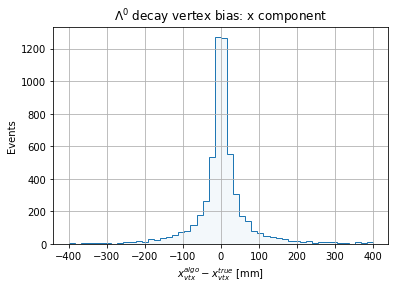

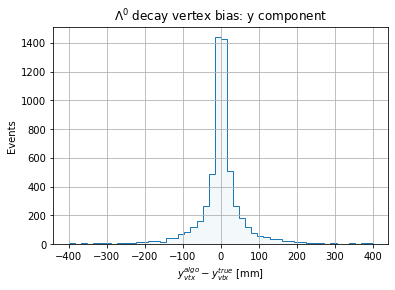

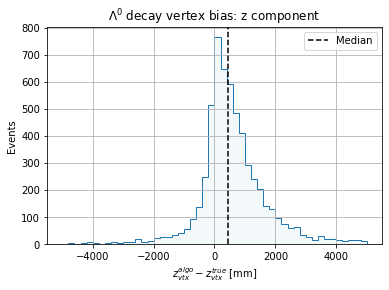

In [45]:
bias_boundary_dictionary = {
    'x': (-400,400),
    'y': (-400,400),
    'z': (-5000,5000),
}

for comp in ['x', 'y', 'z']:
    fitted_feature = 'L_ENDVERTEX_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()

    plot_args = {
        'axis_label': '$' + comp + '^{algo}_{vtx} - ' + comp + '^{true}_{vtx}$ [mm]',
        'plot_title': '$\Lambda^0$ decay vertex bias: ' + comp + " component",
        'file_name': 'Lambda_endvertex_' + comp + '_bias',
        'binning': 50,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': False
    }
    
    if comp == 'z':
        plot_args['median_line'] = True

    plot_single_histogram(
        df_events[fitted_feature] - df_events[true_feature],
        **plot_args)

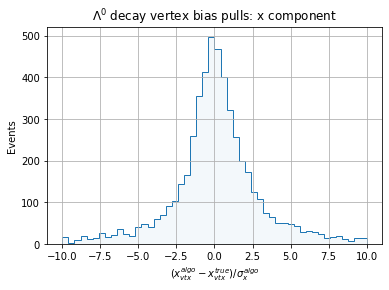

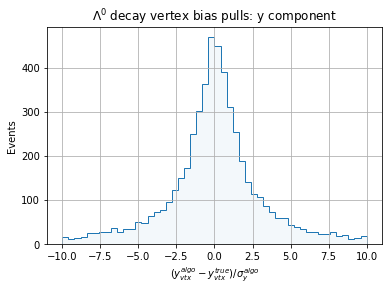

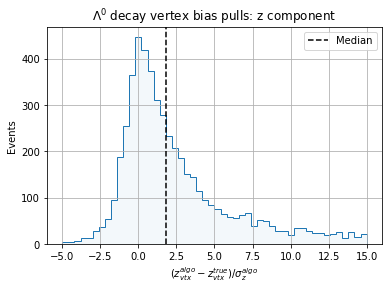

In [46]:
bias_boundary_dictionary = {
    'x': (-10,10),
    'y': (-10,10),
    'z': (-5,15),
}

for comp in ['x', 'y', 'z']:
    fitted_feature = 'L_ENDVERTEX_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()
    error_feature = 'L_ENDVERTEX_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': '$(' + comp + '^{algo}_{vtx} - ' + comp + '^{true}_{vtx})/\sigma^{algo}_{' + comp + '}$',
        'plot_title': '$\Lambda^0$ decay vertex bias pulls: ' + comp + " component",
        'file_name': 'Lambda_endvertex_' + comp + '_bias_pulls',
        'binning': 50,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': False
    }
    
    if comp == 'z':
        plot_args['median_line'] = True

    plot_single_histogram(
        (df_events[fitted_feature] - df_events[true_feature])/df_events[error_feature],
        **plot_args)

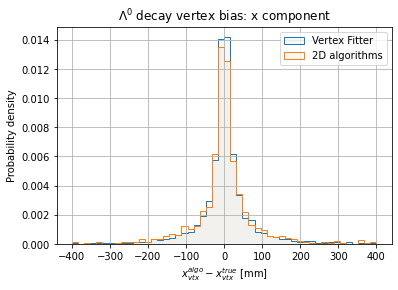

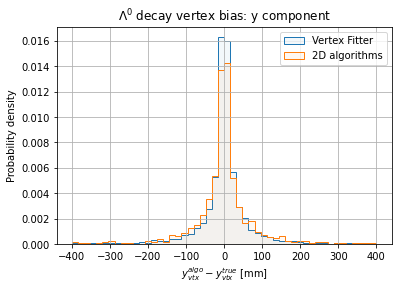

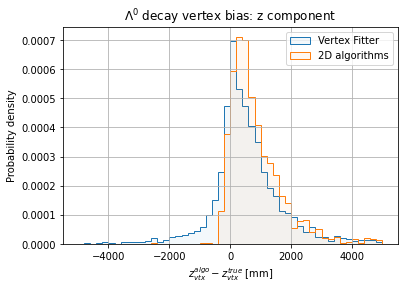

In [47]:
bias_boundary_dictionary = {
    'x': (-400,400),
    'y': (-400,400),
    'z': (-5000,5000),
}

for comp in ['x', 'y', 'z']:
    fitted_feature = 'L_ENDVERTEX_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()

    plot_args = {
        'axis_label': '$' + comp + '^{algo}_{vtx} - ' + comp + '^{true}_{vtx}$ [mm]',
        'plot_title': '$\Lambda^0$ decay vertex bias: ' + comp + " component",
        'file_name': 'Lambda_endvertex_' + comp + '_bias_2D_vs_3D',
        'binning': 50,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': True
    }

    plot_2D_vs_3D_histograms(
        df_events,
        df_events[fitted_feature] - df_events[true_feature],
        **plot_args)

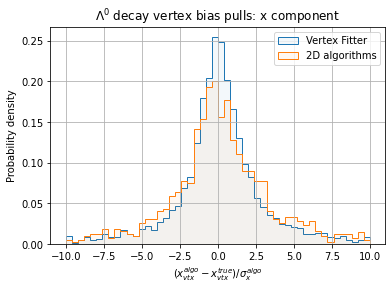

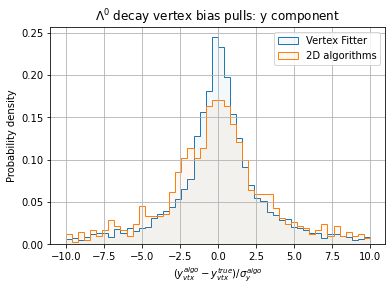

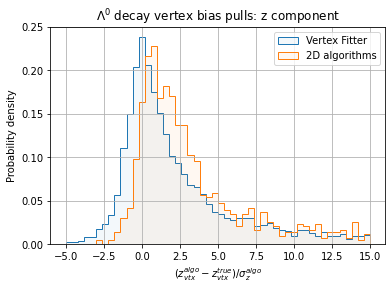

In [48]:
bias_boundary_dictionary = {
    'x': (-10,10),
    'y': (-10,10),
    'z': (-5,15),
}

for comp in ['x', 'y', 'z']:
    fitted_feature = 'L_ENDVERTEX_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()
    error_feature = 'L_ENDVERTEX_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': '$(' + comp + '^{algo}_{vtx} - ' + comp + '^{true}_{vtx})/\sigma^{algo}_{' + comp + '}$',
        'plot_title': '$\Lambda^0$ decay vertex bias pulls: ' + comp + " component",
        'file_name': 'Lambda_endvertex_' + comp + '_bias_pulls_2D_vs_3D',
        'binning': 50,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': True
    }

    plot_2D_vs_3D_histograms(
        df_events,
        (df_events[fitted_feature] - df_events[true_feature])/df_events[error_feature],
        **plot_args)

# Horizontality
"Horizontality" is a measure of how "horizontal" the decay plane is, i.e. its angle with the xz curving plane. Useful to check if events have been reconstructed "upside down".

In [49]:
def row_a_vec(row, p_pvec_column, pim_pvec_column):
    return np.cross(row[p_pvec_column], row[pim_pvec_column])

In [50]:
def row_a_norm(row, avec_column):
    return np.linalg.norm(row[avec_column])

In [51]:
def feature_component(series, component):
    return series.map(lambda x: x[component])

In [52]:
df_events

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,Lb_M,Lb_MM,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,L_M,L_MM,...,pim_PP_POSMOMCOV_1_1,pim_PP_POSMOMCOV_1_3,pim_PP_POSMOMCOV_1_4,pim_PP_POSMOMCOV_1_5,pim_PP_POSMOMCOV_3_3,pim_PP_POSMOMCOV_3_4,pim_PP_POSMOMCOV_3_5,pim_PP_POSMOMCOV_4_4,pim_PP_POSMOMCOV_4_5,pim_PP_POSMOMCOV_5_5
0,1.674753,0.053259,0.004623,5548.595304,5994.525949,461.983261,-78.247981,6504.222043,1098.518302,1116.608101,...,0.156104,0.054083,-1.250532,1.336292,135.629715,-9.136084,3142.555664,17.418783,-213.811951,7.316263e+04
1,0.880395,-0.130333,15.654301,4900.959051,5196.066164,209.545799,199.243538,4381.083975,1228.240710,1286.308889,...,1.845794,-4.761426,-4.757078,-16.119181,2562.330811,9.229958,9031.324219,43.331825,32.646484,3.185937e+04
2,0.893069,-0.210212,27.346294,5669.609293,5447.484208,84.953310,-116.199707,5557.096303,1196.546077,1204.210206,...,0.156974,-0.272185,-2.498910,9.883920,760.612305,745.142334,-28860.775391,787.374390,-28372.277344,1.099216e+06
3,0.605714,-0.203049,22.148035,5645.205401,5601.574674,-202.498747,18.725639,3762.349599,1179.755864,1134.066434,...,0.158962,-0.209039,-1.985822,-4.321545,1088.073242,209.480865,26939.328125,90.186363,5198.505859,6.694764e+05
4,0.636031,-0.090822,-65.799311,5666.024183,5523.351851,-207.686722,152.674077,7297.794399,1142.059990,1140.502451,...,0.171479,0.277545,-2.941218,-7.591522,503.966400,-231.546097,-13094.367188,201.608795,6041.502441,3.405917e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5799,1.244353,0.273491,26.617082,5791.405084,6034.812168,303.069644,143.432016,6927.412624,1159.904419,1176.455599,...,1.251937,-2.488792,-19.226019,-123.327477,909.107849,1038.543579,42415.023438,1501.186279,48571.347656,1.983485e+06
5800,0.771442,-0.198648,-45.869868,9423.309520,9199.005287,-114.713797,-98.392843,5366.717903,5211.399379,2499.554590,...,0.975354,-11.960934,-1.553255,54.025459,13881.547852,-4576.853027,-64122.265625,1564.207886,21157.076172,2.963137e+05
5801,0.893271,-0.240819,-8.364338,5179.496251,5229.171622,-104.381881,-225.769432,4373.238772,840.462502,1165.228188,...,1.932934,-4.882315,-2.684560,7.398481,2144.610107,197.797516,-3460.504395,26.012659,-318.839905,5.589844e+03
5802,0.421768,-0.947067,-73.637508,5397.810490,5126.501383,-192.066143,-297.004409,4468.714184,1100.837596,1124.614171,...,0.929874,-5.542767,-0.706738,-174.402390,1382.818115,-2486.728760,44215.328125,4699.990723,-79816.640625,1.418817e+06


In [53]:
## This computes (once) a new column in df named 'momenta_prefix_h',
## containing the related horizontality. Returns the related column.
def compute_horizontality(
    df: pd.DataFrame,
    momenta_prefix: str,
    p_px_column: str,
    p_py_column: str,
    p_pz_column: str,
    pim_px_column: str,
    pim_py_column: str,
    pim_pz_column :str,
):
      
    p_pvec_column = momenta_prefix + "_p_p_vec"
    pim_pvec_column = momenta_prefix + "_pim_p_vec"
    avec_column = momenta_prefix + "_a_vec"
    anorm_column = momenta_prefix + "_a_norm"
    ahat_column = momenta_prefix + "_a_hat"
    h_column = momenta_prefix + "_h"
    
    df[p_pvec_column] = list(zip(df[p_px_column], df[p_py_column], df[p_pz_column]))
    df[pim_pvec_column] = list(zip(df[pim_px_column], df[pim_py_column], df[pim_pz_column]))
    df[avec_column] = df.apply(lambda row: row_a_vec(row, p_pvec_column, pim_pvec_column), axis=1)
    df[anorm_column] = df.apply(lambda row: row_a_norm(row, avec_column), axis=1)
    df[ahat_column] = df[avec_column]/df[anorm_column]
    df[h_column] = feature_component(df[ahat_column], 1) * df['Polarity'] * np.sign(df['L_ID'])
    
    df.drop(columns=[
        p_pvec_column,
        pim_pvec_column,
        avec_column,
        anorm_column,
        ahat_column
    ], inplace=True)
    
    return h_column

In [54]:
h_reco_DTF = compute_horizontality(
    df=df_events, momenta_prefix="DTF_FixJPsi",
    p_px_column='DTF_FixJPsi_p_PX', p_py_column='DTF_FixJPsi_p_PY', p_pz_column='DTF_FixJPsi_p_PZ',
    pim_px_column='DTF_FixJPsi_pim_PX', pim_py_column='DTF_FixJPsi_pim_PY', pim_pz_column='DTF_FixJPsi_pim_PZ'
)

In [55]:
h_truth = compute_horizontality(
    df=df_events, momenta_prefix="MCTRUTH",
    p_px_column='MCTRUTH_p_PX', p_py_column='MCTRUTH_p_PY', p_pz_column='MCTRUTH_p_PZ',
    pim_px_column='MCTRUTH_pim_PX', pim_py_column='MCTRUTH_pim_PY', pim_pz_column='MCTRUTH_pim_PZ'
)

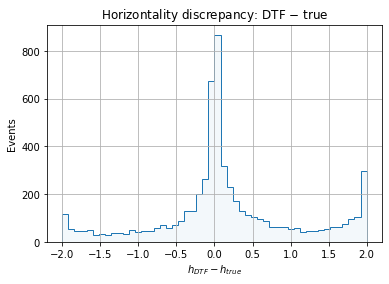

In [56]:
plot_args = {
    'axis_label': '$h_{DTF} - h_{true}$',
    'plot_title': 'Horizontality discrepancy: DTF $-$ true',
    'file_name': 'h_DTF_minus_true',
    'binning': 50,
    'boundaries': (-2,2),
    'log_scale': False,
    'scientific_notation': False,
    'normalized': False
}

plot_single_histogram(
    df_events['DTF_FixJPsi_h'] - df_events['MCTRUTH_h'],
    **plot_args)

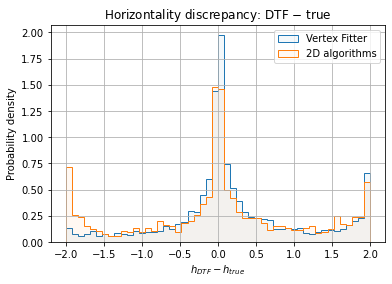

In [57]:
plot_args = {
    'axis_label': '$h_{DTF} - h_{true}$',
    'plot_title': 'Horizontality discrepancy: DTF $-$ true',
    'file_name': 'h_DTF_minus_true_2D_vs_3D',
    'binning': 50,
    'boundaries': (-2,2),
    'log_scale': False,
    'scientific_notation': False,
    'normalized': True
}

plot_2D_vs_3D_histograms(
    df_events,
    df_events['DTF_FixJPsi_h'] - df_events['MCTRUTH_h'],
    **plot_args)

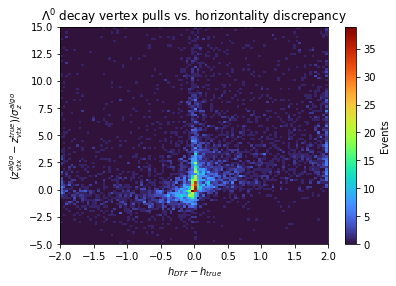

In [58]:
plot_parameters = {
    'binning': 100,
    'title': '$\Lambda^0$ decay vertex pulls vs. horizontality discrepancy',
    'label_x': '$h_{DTF} - h_{true}$',
    'label_y': '$(z^{algo}_{vtx} - z^{true}_{vtx})/\sigma^{algo}_{z}$',
    'show_title': True,
    'black_and_white': False,
    'range_x': [-2,2],
    'range_y': [-5,15],
    'file_name': 'h_DTF_minus_true_vs_Lambda_endvertex_z_bias_pulls',
}

plot_single_hist2D(
    df_events['DTF_FixJPsi_h'] - df_events['MCTRUTH_h'],
    (df_events['L_ENDVERTEX_Z'] - df_events['MCTRUTH_L_ENDVERTEX_Z'])/df_events['L_ENDVERTEX_ZERR'],
    **plot_parameters
)